In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import waterfall_chart

In [45]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")

### Wybór zmiennych

In [46]:
df['y'] = 1 - df['S1'].cat.codes

1. Zmienne jakościowe  
a) `Q25` - Did you and [Partner name] attend the same high school?  
b) `ppmarit` -  Marital Status  

2. Zmienne ilościowe  
a) `ppincimp` - Household Income  
b) `Q16` - How many of your relatives do you see in person at least once a month?
 Include parents, brothers and sisters, uncles, aunts, cousins,
 grandparents, or others.   

In [47]:
columns = ['Q25', 'ppmarit', 'ppincimp', 'Q16', 'y']

In [48]:
df = df[columns].dropna()

In [49]:
X = df[columns[:4]].copy()
X.loc[:, columns[:3]] = X[columns[:3]].apply(lambda x: x.cat.codes, axis=0)
y = df['y']

### Model

In [50]:
gbm = xgb.XGBClassifier(
     learning_rate =0.1,
     n_estimators=50,
     max_depth=8,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective='binary:logistic',
     nthread=4,
     scale_pos_weight=1,
     seed=27).fit(X, y)

### Zmiana w średniej odpowiedzi modelu

In [117]:
def plot_mean_response(X, model, **kwargs):
    X = X.copy()
    y = [model.predict_proba(X)[:,1].mean()]
    for kwarg in kwargs:
        X.loc[:, kwarg] = kwargs[kwarg]
        y.append(model.predict_proba(X)[:,1].mean())
    waterfall_chart.plot(['intercept'] + list(kwargs.keys()), [y[0]] + list(np.diff(y)), formatting='{:,.2f}')

a) `Q25` - Did you and [Partner name] attend the same high school?  
b) `ppmarit` -  Marital Status  
c) `ppincimp` - Household Income  
d) `Q16` - How many of your relatives do you see in person at least once a month?

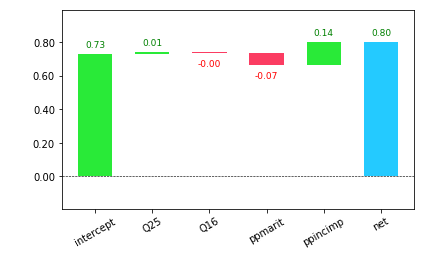

In [118]:
plot_mean_response(X, gbm, Q25=1, Q16=8, ppmarit=3, ppincimp=13)

W tej analizie widać wyraźny spadek predykcji w przypadku gdy dana osoba jest rozwiedziona (ppmarit=3)
oraz nadrobienie tych strat kiedy okazuje się, że osoba jest dosyć zamożna.

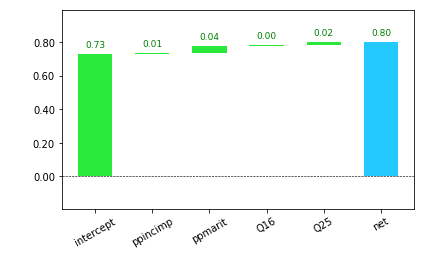

In [105]:
plot_mean_response(X, gbm, ppincimp=13, ppmarit=3, Q16=8, Q25=1)

Zmiana kolejności warunkowania spowodowała zmianę interpretacji. Wynika to z faktu, że jeśli wiemy, że dana osoba jest zamożna to fakt, że jest rozwiedziona przestaje przeszkadzać a nawet powoduje wzrost predykcji. Jest to trochę sprzeczne z intuicją dlatego należałoby dokładniej zbadać model.